# Setup colab 

In [ ]:
#from google.colab import drive
#
#drive.mount('/content/drive')

path = '/content/drive/MyDrive/PoliMI/Dataset1_BankClients.xlsx'

> **IMPORTANT**
> Nel caso si utilizzi google Colab c'è da caricare i file di input.

# Setup locale

In [2]:
# Path su linux
#file_path = '../data/Dataset2_Needs.xls'

# Path su windows - comando da inserire 
file_path = "C:/Users/pc/Desktop/politecnico/b-FINTECH/business cases/Fintech_BC/BC2/data/Dataset2_Needs.xls"

# Data Loading  

In [3]:
import pandas as pd

# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')
products_df = pd.read_excel(file_path, sheet_name='Products')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

# Data Exploration

In [4]:
def create_variable_summary(df, metadata_df):
    # Create empty lists to store the chosen statistics
    stats_dict = {
        'Variable': [],
        'Description': [],
        'Mean': [],
        'Std': [],
        'Missing': [],
        'Min': [],
        'Max': []
    }

    # Create a metadata dictionary for easy lookup
    meta_dict = dict(zip(metadata_df['Metadata'], metadata_df['Unnamed: 1']))

    for col in df.columns:
        stats_dict['Variable'].append(col)
        stats_dict['Description'].append(meta_dict.get(col, 'N/A'))

        # Calculate some statistics for each column
        if pd.api.types.is_numeric_dtype(df[col]):
            stats_dict['Mean'].append(f"{df[col].mean():.2f}")
            stats_dict['Std'].append(f"{df[col].std():.2f}")
            stats_dict['Min'].append(f"{df[col].min():.2f}")
            stats_dict['Max'].append(f"{df[col].max():.2f}")
        else:
            stats_dict['Mean'].append('N/A')
            stats_dict['Std'].append('N/A')
            stats_dict['Min'].append('N/A')
            stats_dict['Max'].append('N/A')

        stats_dict['Missing'].append(df[col].isna().sum())

    return pd.DataFrame(stats_dict)


# Create summary tables
print("NEEDS VARIABLES SUMMARY:")
needs_summary = create_variable_summary(needs_df, metadata_df)
display(needs_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))

print("\nPRODUCTS VARIABLES SUMMARY:")
products_summary = create_variable_summary(products_df, metadata_df)
display(products_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))


NEEDS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
ID,Numerical ID,2500.50,1443.52,0,1.00,5000.00
Age,"Age, in years",55.25,11.97,0,18.00,97.00
Gender,"Gender (Female = 1, Male = 0)",0.49,0.50,0,0.00,1.00
FamilyMembers,Number of components,2.51,0.76,0,1.00,5.00
FinancialEducation,Normalized level of Financial Education (estimate),0.42,0.15,0,0.04,0.90
RiskPropensity,Normalized Risk propensity from MIFID profile,0.36,0.15,0,0.02,0.88
Income,Income (thousands of euros); estimate,62.99,44.36,0,1.54,365.32
Wealth,Wealth (thousands of euros); sum of investments and cash accounts,93.81,105.47,0,1.06,2233.23
IncomeInvestment,Boolean variable for Income investment; 1 = High propensity,0.38,0.49,0,0.00,1.00
AccumulationInvestment,Boolean variable for Accumulation/growth investment; 1 = High propensity,0.51,0.50,0,0.00,1.00



PRODUCTS VARIABLES SUMMARY:


Variable,Description,Mean,Std,Missing,Min,Max
IDProduct,Product description,6.00,3.32,0,1.00,11.00
Type,"1 = Accumulation product, 0 = Income product",0.64,0.50,0,0.00,1.00
Risk,Normalized Synthetic Risk Indicator,0.43,0.24,0,0.12,0.88


In [5]:
# Plot the distribution of the data for each variable
import matplotlib.pyplot as plt
import seaborn as sns
def plot_distribution(df, variable):
    plt.figure(figsize=(10, 6))
    sns.histplot(df[variable], kde=True)
    plt.title(f'Distribution of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()
# Plot distributions for numeric variables in needs_df
numeric_vars = needs_df.select_dtypes(include=['int64', 'float64']).columns
for var in numeric_vars:
    pass
    #plot_distribution(needs_df, var) # Inutile perchè le feature sono tutte bilanciate ed abbastanza distribuite bene a parte l'income e la wealth

# Data Preprocessing

In [6]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Change Wealth in log scale
def prepare_features(df):
    X = df.copy()

    # Log transformation for Wealth and Income
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])

    #X['financial_sophistication'] = (X['FinancialEducation'] +  X['RiskPropensity'])*X['Wealth_log']

    # Select features for modeling
    features_base = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                    'RiskPropensity', 'Wealth_log', 'Income_log']

    # Normalize all features
    scaler = MinMaxScaler()
    X_base = pd.DataFrame(scaler.fit_transform(X[features_base]), columns=features_base)

    return X_base

# Drop ID column as it's not needed for analysis
needs_df = needs_df.drop('ID', axis=1)

# Prepare features
X_base = prepare_features(needs_df)
y_income = needs_df['IncomeInvestment']
y_accum = needs_df['AccumulationInvestment']

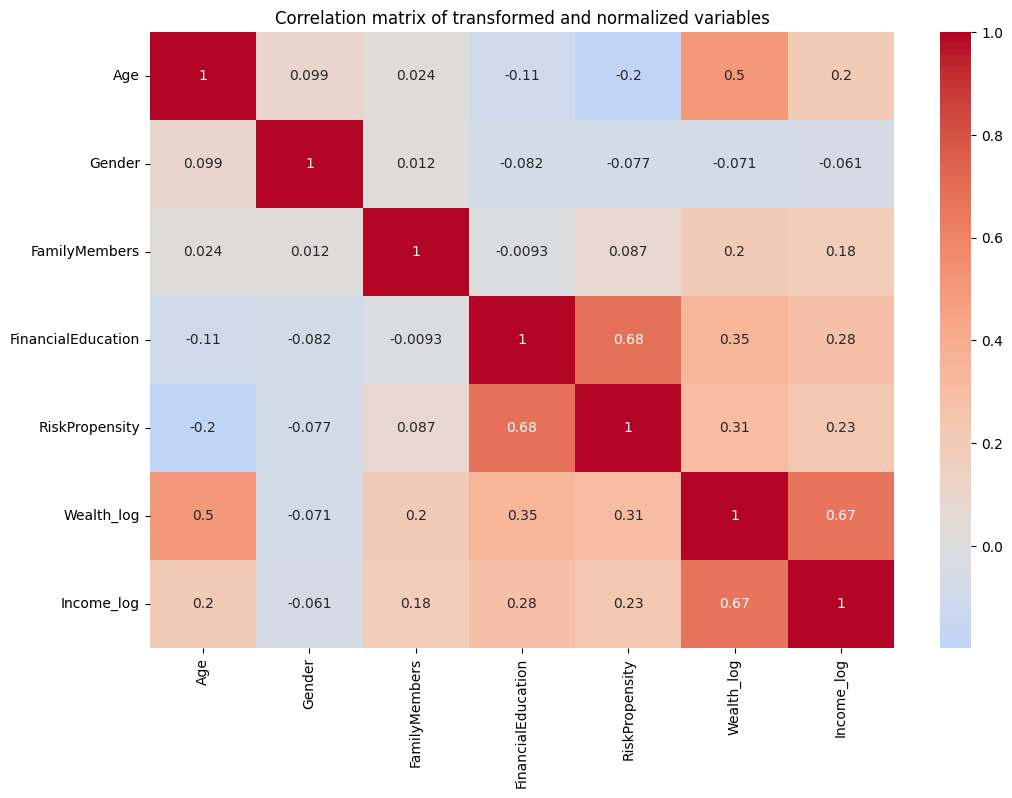

In [7]:
# Get all numeric columns including transformed ones (and not transformed, for comparison)
numeric_cols = X_base.select_dtypes(include=['float64', 'int64']).columns

# Create correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X_base[numeric_cols].corr(),
            annot=True,
            cmap='coolwarm',
            center=0)
plt.title('Correlation matrix of transformed and normalized variables')
plt.show()

# Model Training

In [11]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabulate import tabulate

# Step 1: Feature engineering and transformation function
def prepare_features(df):
    X = df.copy()

    # Log transformation for Wealth and Income
    X['Wealth_log'] = np.log1p(X['Wealth'])
    X['Income_log'] = np.log1p(X['Income '])

    # Create Income/Wealth ratio
    X['Income_Wealth_Ratio'] = X['Income '].div(X['Wealth'].replace(0, np.nan)).fillna(X['Income '].max())
    X['Income_Wealth_Ratio_log'] = np.log1p(X['Income_Wealth_Ratio'])

    # Select features for modeling
    features_base = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                    'RiskPropensity', 'Wealth_log', 'Income_log']

    features_engineered = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation',
                          'RiskPropensity', 'Income_Wealth_Ratio_log']

    # Normalize all features
    scaler = MinMaxScaler()
    X_base = pd.DataFrame(scaler.fit_transform(X[features_base]), columns=features_base)
    X_engineered = pd.DataFrame(scaler.fit_transform(X[features_engineered]), columns=features_engineered)

    return X_base, X_engineered

# Step 2: Data split function
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    return X_train, X_test, y_train, y_test

# Step 3: Model training and evaluation function
def train_evaluate_model(X_train, y_train, X_test, y_test, model, k_folds=5):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)

        cv_metrics['accuracy'].append(accuracy_score(y_val_fold, y_val_pred))
        cv_metrics['precision'].append(precision_score(y_val_fold, y_val_pred))
        cv_metrics['recall'].append(recall_score(y_val_fold, y_val_pred))
        cv_metrics['f1'].append(f1_score(y_val_fold, y_val_pred))

    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)

    return {
        'cv_metrics': {
            metric: {
                'mean': np.mean(scores),
                'std': np.std(scores)
            } for metric, scores in cv_metrics.items()
        },
        'test_metrics': {
            'accuracy': accuracy_score(y_test, y_test_pred),
            'precision': precision_score(y_test, y_test_pred),
            'recall': recall_score(y_test, y_test_pred),
            'f1': f1_score(y_test, y_test_pred)
        }
    }, model

# Step 4: Display results function
def display_results_table(results_dict, model_name, feature_type):
    cv_data = {
        #'Metric': ['Accuracy', 'Precision', 'Recall', 'F1'],
        'Metric': ['Precision', 'F1'],
        'CV Mean': [
            #results_dict['cv_metrics']['accuracy']['mean'],
            results_dict['cv_metrics']['precision']['mean'],
            #results_dict['cv_metrics']['recall']['mean'],
            results_dict['cv_metrics']['f1']['mean']
        ],
        'CV Std': [
            #results_dict['cv_metrics']['accuracy']['std'],
            results_dict['cv_metrics']['precision']['std'],
            #results_dict['cv_metrics']['recall']['std'],
            results_dict['cv_metrics']['f1']['std']
        ],
        'Test Set': [
            #results_dict['test_metrics']['accuracy'],
            results_dict['test_metrics']['precision'],
            #results_dict['test_metrics']['recall'],
            results_dict['test_metrics']['f1']
        ]
    }

    df = pd.DataFrame(cv_data)
    df = df.round(3)

    print(f"\n{model_name} - {feature_type}")
    print("=" * 60)
    print(tabulate(df, headers='keys', tablefmt='pretty'))


In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import Binarizer
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

# Define models
models = {
    #'SVM': SVC(),
    #'NaiveBayes': GaussianNB(), 
    #'KNN': KNeighborsClassifier(n_neighbors=20),
    #'DecisionTree': DecisionTreeClassifier(random_state=42),
    #'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    #'BetaBinomial': BernoulliNB(alpha=1)  # Using alpha=1.0 gives a beta(1,1) prior
    #'AdaBoost': AdaBoostClassifier(random_state=42),
    #'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

trained_models = {}

# Run analysis
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)
    
    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    
    # Initialize a sub-dictionary for this target
    trained_models[target_name] = {}
    
    for model_name, model in models.items():
        if model_name == 'BetaBinomial':
            # Binarize data for the BetaBinomial model
            binarizer = Binarizer(threshold=0.5)
            X_train_bin = pd.DataFrame(
                binarizer.fit_transform(X_base_train), 
                columns=X_base_train.columns
            )
            X_test_bin = pd.DataFrame(
                binarizer.transform(X_base_test), 
                columns=X_base_test.columns
            )
            results_base, trained_model = train_evaluate_model(X_train_bin, y_train, X_test_bin, y_test, model)
        else:
            results_base, trained_model = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, model)
        
        # Store the trained model
        trained_models[target_name][model_name] = trained_model
        
        display_results_table(results_base, model_name, 'Base Features')
        


Target Variable: Income Investment

RandomForest - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Precision |  0.853  | 0.017  |  0.815   |
| 1 |    F1     |  0.721  | 0.017  |  0.641   |
+---+-----------+---------+--------+----------+

Target Variable: Accumulation Investment

RandomForest - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Precision |  0.827  | 0.022  |  0.804   |
| 1 |    F1     |  0.779  | 0.017  |  0.776   |
+---+-----------+---------+--------+----------+



Target Variable: Income Investment

RandomForest - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Precision |  0.853  | 0.017  |  0.815   |
| 1 |    F1     |  0.721  | 0.017  |  0.641   |
+---+-----------+---------+--------+----------+

Feature Importance Analysis for Income Investment


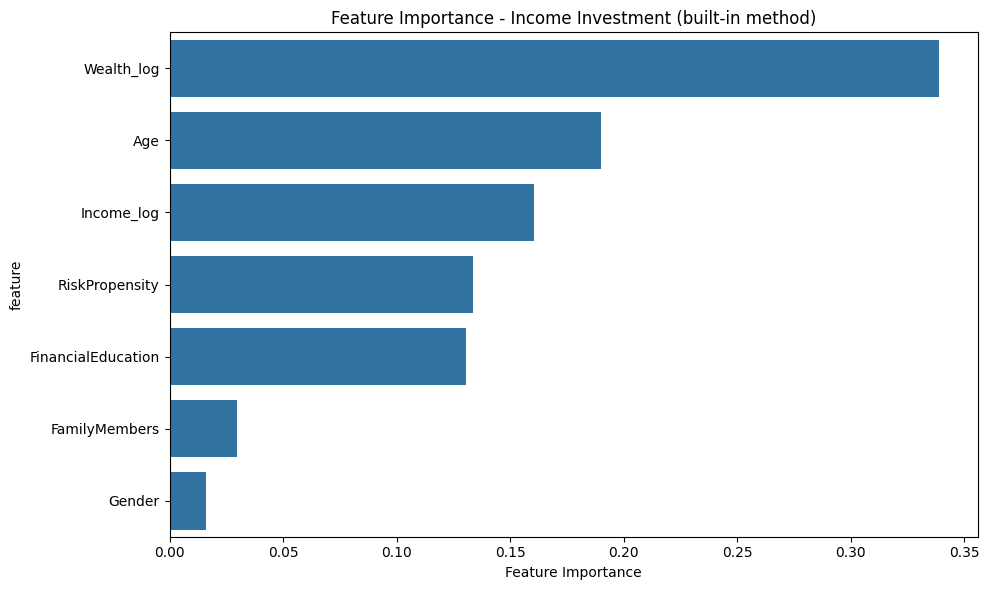

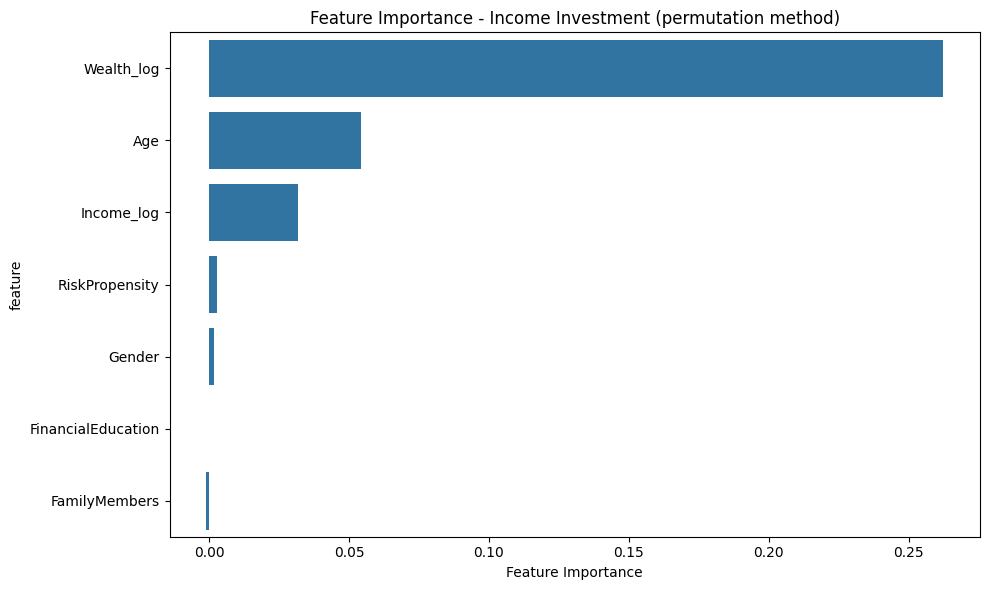


Target Variable: Accumulation Investment

RandomForest - Base Features
+---+-----------+---------+--------+----------+
|   |  Metric   | CV Mean | CV Std | Test Set |
+---+-----------+---------+--------+----------+
| 0 | Precision |  0.827  | 0.022  |  0.804   |
| 1 |    F1     |  0.779  | 0.017  |  0.776   |
+---+-----------+---------+--------+----------+

Feature Importance Analysis for Accumulation Investment


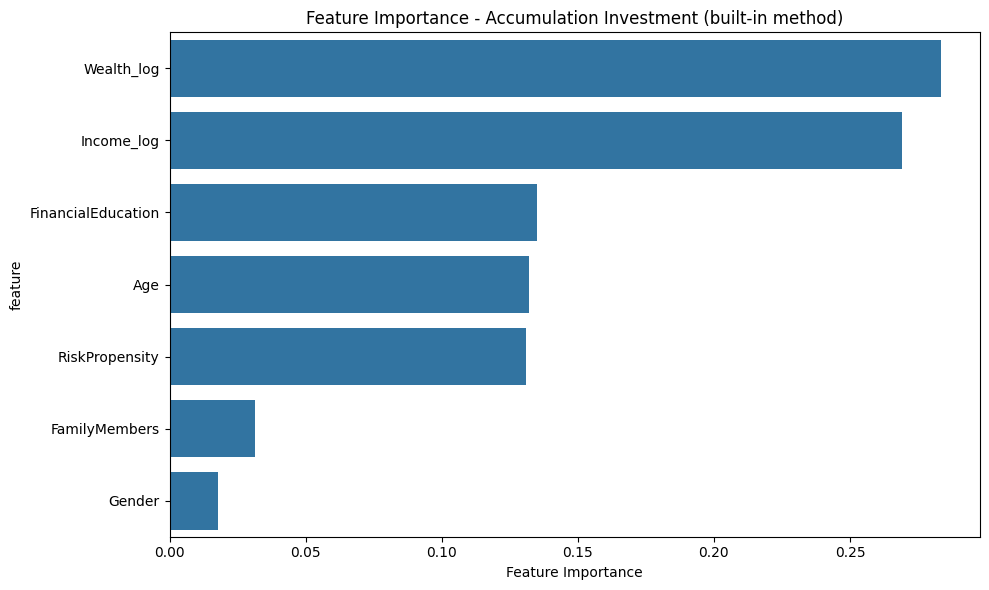

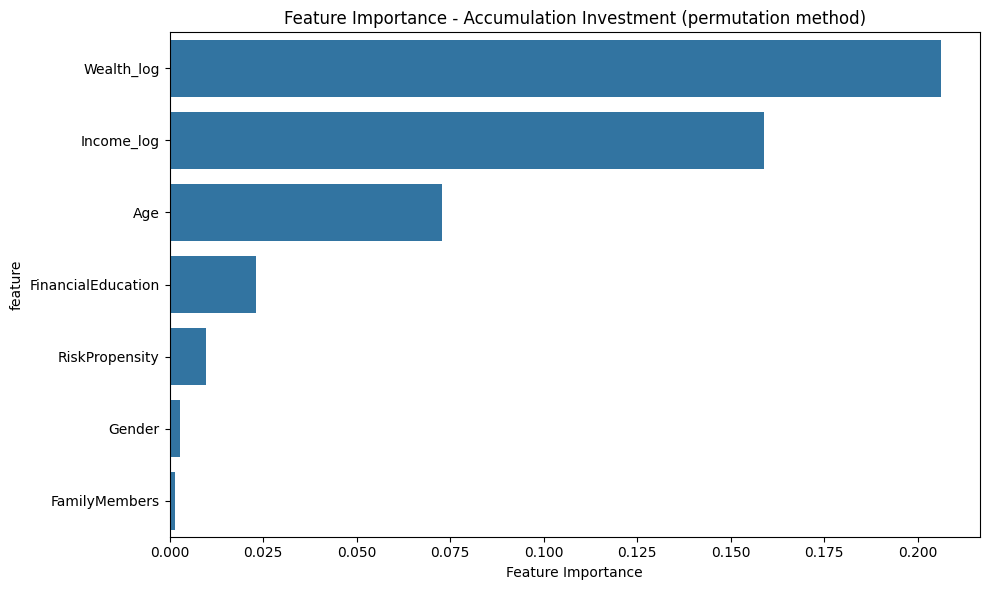

In [13]:
def plot_feature_importance_rf(model, feature_names, title, method='built-in', X_test=None, y_test=None, n_repeats=10):
    """
    Plot feature importance for Random Forest using different methods.
    
    Parameters:
    - model: Trained RandomForestClassifier model
    - feature_names: List of feature names
    - title: Plot title
    - method: 'built-in' (for model's feature_importances_) or 'permutation' (for permutation importance)
    - X_test: Test features (required for permutation importance)
    - y_test: Test labels (required for permutation importance)
    - n_repeats: Number of repeats for permutation importance
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import f1_score
    
    if method == 'built-in':
        # Use Random Forest's built-in feature importance
        importance = model.feature_importances_
    elif method == 'permutation' and X_test is not None and y_test is not None:
        # Permutation importance
        baseline_score = f1_score(y_test, model.predict(X_test))
        
        importance = np.zeros(len(feature_names))
        
        for i in range(len(feature_names)):
            X_test_permuted = X_test.copy()
            for _ in range(n_repeats):
                X_test_permuted.iloc[:, i] = np.random.permutation(X_test_permuted.iloc[:, i])
                score = f1_score(y_test, model.predict(X_test_permuted))
                importance[i] += np.max((baseline_score - score), 0)
            importance[i] /= n_repeats
    else:
        raise ValueError("Invalid method or missing data for permutation importance")
    
    # Create and plot importance dataframe
    importances_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances_df, x='importance', y='feature')
    plt.title(f'{title} ({method} method)')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return importances_df

# Codice aggiornato per eseguire l'analisi di feature importance per Random Forest
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTarget Variable: {target_name}")
    print("=" * 80)
    
    X_base_train, X_base_test, y_train, y_test = split_data(X_base, y)
    
    # Utilizza solo il modello Random Forest come nel tuo codice
    model_name = 'RandomForest'
    model = models[model_name]
    
    # Addestra il modello
    results_base, trained_model = train_evaluate_model(X_base_train, y_train, X_base_test, y_test, model)
    
    # Memorizza il modello addestrato
    trained_models[target_name][model_name] = trained_model
    
    # Mostra i risultati
    display_results_table(results_base, model_name, 'Base Features')
    
    # Plot feature importance utilizzando il metodo built-in di Random Forest
    print(f"\nFeature Importance Analysis for {target_name}")
    print("=" * 50)
    
    built_in_importance = plot_feature_importance_rf(
        trained_model, 
        X_base_train.columns, 
        f'Feature Importance - {target_name}', 
        method='built-in'
    )
    
    # Plot permutation importance (più accurato ma più lento)
    perm_importance = plot_feature_importance_rf(
        trained_model,
        X_base_train.columns,
        f'Feature Importance - {target_name}',
        method='permutation',
        X_test=X_base_test,
        y_test=y_test,
        n_repeats=100
    )

<br>

Now let's move to a class of more complex models, a **Multilayer Perceptron (MLP) Neural Network (NN)**, a family of powerful and flexible models.


## Multi-Layer Perceptron implementation
First we enhanced the MLP with the architecture we describe below and then we also tried to do an hyper-parameter search focusing on the number of layers and on the 
number of neurons. Finally for the selected model we even perform a k-fold cross validation with 5 folds.

### NN architecture rationale
* **Decreasing Layer Sizes** (128 → 64 → 32 → 16 → 1): Creates a bottleneck architecture that forces the NN to learn increasingly compact representations (maybe reducing the risk of overfitting).
* **Batch Normalization**: Makes training of NN faster and more stable through normalization of the layers' inputs by re-centering and re-scaling. [Batch Normalization](https://arxiv.org/abs/1502.03167) addresses internal covariate shift, particularly important with our mixed-scale financial features.
* **Dropout={0.1,0.2}**: [Dropout](https://jmlr.org/papers/v15/srivastava14a.html) is a light regularization that maintains most information while preventing co-adaptation. Basically, dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs, we alternate it for a less aggressive regularization.
* **ReLU**: Provides non-linearity without gradient vanishing issues common in financial data modeling, we also put a sigmoid inside an hidden layer.
* **Sigmoid Output**: Transforms final layer output into probability scores for binary classification.

### Training configuration and reasoning
* **Binary Cross Entropy Loss**: Natural choice for binary classification with probabilistic interpretation
* **AdamW Optimizer (lr=0.001)**: Adaptive learning rates help handle different feature scales, to which we will add a scheduler for better performance.
* **Batch size=128**: Good balance between computational efficiency and gradient estimation.
* **500 epochs**: Sufficient iterations for convergence with validation monitoring every 50 epochs.

### Data handling
* Custom PyTorch Dataset class for efficient data loading.
* Separate training and evaluation pipelines.
* Comprehensive metrics evaluation (accuracy, precision, recall, F1), comparable to previous models.

### Key Enhancements
* **Learning rate scheduler**: Implements **ReduceLROnPlateau** for **adaptive learning rate adjustment** - it's a smart technique, look at [this paper](https://arxiv.org/abs/1506.01186) and [this other one](https://arxiv.org/abs/1803.09820):
  * Reduces learning rate by 50% after 30 epochs without improvement.
  * Helps overcome plateaus and fine-tune learning in later stages.

* **Performance monitoring**:
  * Tracks training and validation losses across epochs.
  * Monitors validation accuracy progression.
  * Stores metrics for visualization.

* **Visualization capabilities**:
  * Real-time learning curves display.
  * Side-by-side loss and accuracy plots.
  * Visual assessment of model convergence and potential overfitting. Overfitting occurs when a model **performs well on training data but poorly on validation data**. In learning curves, this appears as:  
    * **Training loss decreasing steadily**.
    * **validation loss stops improving (plateaus) or increases** after a certain epoch.
    * A **large gap** between training and validation performance indicates overfitting, suggesting the need for **regularization, more data, or early stopping**.

<br>


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Custom dataset class
class InvestmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Enhanced MLP class, 1 more layer
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            # New initial 128 neurons layer
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),  # Dropout 0.2
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),  # Prima ReLU
            nn.Dropout(0.1),  # Alternate  0.1
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),  
            nn.Dropout(0.2),  # Back to 0.2
            
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),  # Terza ReLU
            nn.Dropout(0.1),  # Alternato a 0.1
            
            nn.Linear(16, 1),
            nn.Sigmoid()  # Output activation probability: Sigmoid 
        )
    
    def forward(self, x):
        return self.layers(x)

# Classe per l'Early Stopping
class EarlyStopping:
    def __init__(self, patience=50, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0

# Training with learning rate scheduler and early stopping
def train_model_with_curves(model, train_loader, val_loader, criterion, optimizer, epochs=500, patience=50):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=30)
    early_stopping = EarlyStopping(patience=patience)
    
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().numpy())
                val_true.extend(y_batch.numpy())

        # Calcola metriche medie
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_true, val_preds)
        
        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        early_stopping(avg_val_loss, model)

        if (epoch + 1) % 50 == 0 or early_stopping.early_stop:
            print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, '
                  f'Val Accuracy: {val_accuracy:.4f}')
        
        if early_stopping.early_stop:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            # Load best weights
            model.load_state_dict(early_stopping.best_model_state)
            break

    # Plot learning curves
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Model evaluation
def evaluate_nn_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().numpy())
            all_true.extend(y_batch.numpy())

    return {
        #'accuracy': accuracy_score(all_true, all_preds),
        'precision': precision_score(all_true, all_preds),
        #'recall': recall_score(all_true, all_preds),
        'f1': f1_score(all_true, all_preds)
    }

# Training and evaluation for both targets
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTraining Neural Network for {target_name}")
    print("=" * 50)

    X_train, X_test, y_train, y_test = split_data(X_base, y)

    # Create data loaders
    train_dataset = InvestmentDataset(X_train, y_train)
    test_dataset = InvestmentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model, criterion, optimizer
    model = MLP(input_size=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    # Train model with early stopping
    train_model_with_curves(model, train_loader, test_loader, criterion, optimizer, patience=50)

    # Display final metrics
    print(f"\nResults for {target_name}")
    print("=" * 50)

    train_metrics = evaluate_nn_metrics(model, train_loader)
    test_metrics = evaluate_nn_metrics(model, test_loader)

    metrics_df = pd.DataFrame({
        'Training': train_metrics,
        'Test': test_metrics
    }).round(3)

    print("\nNeural Network Metrics:")
    print(metrics_df)

In [ ]:
class InvestmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class MLP(nn.Module):
    def __init__(self, input_size, n_layers=3, neurons=(128, 64, 32)):
        super(MLP, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Crea le layer intermedie
        for i, neurons_count in enumerate(neurons[:n_layers]):
            layers.extend([
                nn.Linear(prev_size, neurons_count),
                nn.BatchNorm1d(neurons_count),
                nn.ReLU(),
                nn.Dropout(0.2 if i % 2 == 0 else 0.1)
            ])
            prev_size = neurons_count
            
        # Aggiungi l'ultimo layer di output
        layers.extend([
            nn.Linear(prev_size, 1),
            nn.Sigmoid()
        ])
        
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

class EarlyStopping:
    def __init__(self, patience=50, min_delta=0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0

def train_model_with_curves(model, train_loader, val_loader, criterion, optimizer, epochs=500, patience=50):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=30)
    early_stopping = EarlyStopping(patience=patience)
    train_losses = []
    val_losses = []
    val_accuracies = []
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                y_pred = model(X_batch).squeeze()
                val_loss += criterion(y_pred, y_batch).item()
                val_preds.extend((y_pred > 0.5).float().numpy())
                val_true.extend(y_batch.numpy())
        
        # Calcola metriche medie
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = accuracy_score(val_true, val_preds)
        
        # Store metrics
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        # Update learning rate
        scheduler.step(avg_val_loss)
        
        # Early stopping check
        early_stopping(avg_val_loss, model)
        if (epoch + 1) % 50 == 0 or early_stopping.early_stop:
            print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, '
                  f'Val Accuracy: {val_accuracy:.4f}')
        
        if early_stopping.early_stop:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break
            
        # Load best weights
        model.load_state_dict(early_stopping.best_model_state)
    
    return model

def hyperparameter_search(X_train, y_train, X_test, y_test):
    # Definisci le configurazioni da provare
    layer_configs = [3, 4]
    neurons_config = (128, 64, 32)
    
    best_results = {}
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for n_layers in layer_configs:
        print(f"\nProvo configurazione con {n_layers} layers")
        print("=" * 50)
        
        fold_results = []
        
        # K-fold cross validation
        for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
            print(f"\nFold {fold + 1}/5")
            print("-" * 30)
            
            # Crea dataset per questo fold
            X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # Crea i dataloader
            train_dataset = InvestmentDataset(X_fold_train, y_fold_train)
            val_dataset = InvestmentDataset(X_fold_val, y_fold_val)
            train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=64)
            
            # Inizializza modello e ottimizzatore
            model = MLP(input_size=X_train.shape[1], n_layers=n_layers, neurons=neurons_config)
            criterion = nn.BCELoss()
            optimizer = optim.AdamW(model.parameters(), lr=0.001)
            
            # Train model
            trained_model = train_model_with_curves(
                model, 
                train_loader, 
                val_loader, 
                criterion, 
                optimizer,
                patience=50
            )
            
            # Valuta il modello sul test set di questo fold
            metrics = evaluate_nn_metrics(trained_model, val_loader)
            fold_results.append(metrics['f1'])
        
        # Calcola media delle metriche su tutti i folds
        avg_f1 = np.mean(fold_results)
        best_results[n_layers] = {
            'avg_f1': avg_f1,
            'fold_results': fold_results
        }
    
    return best_results

def evaluate_nn_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch).squeeze()
            all_preds.extend((y_pred > 0.5).float().numpy())
            all_true.extend(y_batch.numpy())
    
    return {
        #'accuracy': accuracy_score(all_true, all_preds),
        'precision': precision_score(all_true, all_preds),
        #'recall': recall_score(all_true, all_preds),
        'f1': f1_score(all_true, all_preds)
    }

# Training loop principale
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTraining Neural Network for {target_name}")
    print("=" * 50)
    
    X_train, X_test, y_train, y_test = split_data(X_base, y)
    
    # Esegui ricerca iperparametri
    results = hyperparameter_search(X_train, y_train, X_test, y_test)
    
    # Trova la migliore configurazione
    best_n_layers = max(results.items(), key=lambda x: x[1]['avg_f1'])[0]
    print(f"\nBest configuration found:")
    print(f"Number of layers: {best_n_layers}")
    print(f"Average F1-score across folds: {results[best_n_layers]['avg_f1']:.4f}")
    print("\nResults for each fold:")
    for i, score in enumerate(results[best_n_layers]['fold_results']):
        print(f"Fold {i+1}: F1-score = {score:.4f}")

## Feature Importance analysis

The following implementation includes different steps.

### Enhanced model evaluation
* Updated `train_evaluate_model` function now returns the trained model.
* Maintains all previous metrics and cross-validation capabilities.
* Enables subsequent feature importance analysis.

### Feature Importance visualization
* New `plot_feature_importance` function creates clear visual representations.
* Uses XGBoost's built-in feature importance scores, i.e., XGBoost directly calculates importance through its `feature_importances_` attribute.
* Displays results as sorted bar plots for direct interpretation.

<br>

In [ ]:
def plot_feature_importance_nn(model, feature_names, title, method='permutation', X_test=None, y_test=None, n_repeats=10):
    """
    Plot feature importance for neural network using different methods.
    
    Parameters:
    - model: Trained PyTorch model
    - feature_names: List of feature names
    - title: Plot title
    - method: 'weights' (for weight-based importance) or 'permutation' (for permutation importance)
    - X_test: Test features (required for permutation importance)
    - y_test: Test labels (required for permutation importance)
    - n_repeats: Number of repeats for permutation importance
    """
    if method == 'weights':
        # Weight-based feature importance (for first layer weights)
        weights = model.layers[0].weight.data.numpy()
        importance = np.mean(np.abs(weights), axis=0)
    elif method == 'permutation' and X_test is not None and y_test is not None:
        # Permutation importance
        baseline_score = f1_score(y_test, (model(torch.FloatTensor(X_test.values)).squeeze() > 0.5).float().numpy())
        
        importance = np.zeros(len(feature_names))
        
        for i in range(len(feature_names)):
            X_test_permuted = X_test.copy()
            for _ in range(n_repeats):
                X_test_permuted.iloc[:, i] = np.random.permutation(X_test_permuted.iloc[:, i])
                y_pred = model(torch.FloatTensor(X_test_permuted.values)).squeeze()
                score = f1_score(y_test, (y_pred > 0.5).float().numpy())
                importance[i] += np.max((baseline_score - score),0)
            importance[i] /= n_repeats
    else:
        raise ValueError("Invalid method or missing data for permutation importance")
    
    # Create and plot importance dataframe
    importances_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances_df, x='importance', y='feature')
    plt.title(f'{title} ({method} method)')
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    return importances_df

# Modifica nella parte di training e valutazione
for target_name, y in [('Income Investment', y_income), ('Accumulation Investment', y_accum)]:
    print(f"\nTraining Neural Network for {target_name}")
    print("=" * 50)

    X_train, X_test, y_train, y_test = split_data(X_base, y)
    
    # Create data loaders
    train_dataset = InvestmentDataset(X_train, y_train)
    test_dataset = InvestmentDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model, criterion, optimizer
    model = MLP(input_size=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    # Train model with early stopping
    train_model_with_curves(model, train_loader, test_loader, criterion, optimizer, patience=50)

    # Display final metrics
    print(f"\nResults for {target_name}")
    print("=" * 50)

    train_metrics = evaluate_nn_metrics(model, train_loader)
    test_metrics = evaluate_nn_metrics(model, test_loader)

    metrics_df = pd.DataFrame({
        'Training': train_metrics,
        'Test': test_metrics
    }).round(3)

    print("\nNeural Network Metrics:")
    print(metrics_df)
    
    # Plot feature importance
    print(f"\nFeature Importance Analysis for {target_name}")
    print("=" * 50)
    
    # Convert test loader to DataFrame for permutation importance
    X_test_df = X_test.copy()
    y_test_np = y_test.values
    
    # Plot weight-based importance
    weight_importance = plot_feature_importance_nn(
        model, 
        X_train.columns, 
        f'Feature Importance - {target_name}', 
        method='weights'
    )
    
    # Plot permutation importance (more accurate but slower)
    perm_importance = plot_feature_importance_nn(
        model,
        X_train.columns,
        f'Feature Importance - {target_name}',
        method='permutation',
        X_test=X_test_df,
        y_test=y_test_np,
        n_repeats=100
    )

# Recommendation System 

In [ ]:
# Target and model selection
target_name = 'Accumulation Investment'
model_name = 'RandomForest'
y_accum = needs_df['AccumulationInvestment']
X_train, X_test, y_train, y_test = split_data(X_base, y_accum)

# Prepare Features
y_pred = trained_models[target_name][model_name].predict(X_test)

# Filtering accumulation products from our product database
accumulation_products = products_df[products_df['Type'] == 1].copy()
min_risk = accumulation_products['Risk'].min()

# Collecting client IDs and their risk propensities from the test set
# We filter for clients predicted to need accumulation products (y_pred == 1)
client_indices = np.where(y_pred == 1)[0]
target_client_ids = needs_df.iloc[X_test.index[client_indices]].index.values

# Get client information and create additional features
client_data = X_test.iloc[client_indices].copy()
client_risk_propensity = client_data['RiskPropensity'].values
client_age = client_data['Age'].values

# Apply age-based risk adjustment - younger clients can typically handle more risk
age_adjustment_factor = 1 + (0.1 * (1 - client_data['Age']))
adjusted_risk_propensity = client_risk_propensity * age_adjustment_factor.values

# Risk buffer - slightly increase tolerance to find more matches
risk_buffer = 0.05

# Extract product information for matching
product_ids = accumulation_products['IDProduct'].astype(np.uint16).values
product_risks = accumulation_products['Risk'].values

# Initialize lists to store recommendation results
primary_recommendations = []
primary_risk_levels = []
alternative_recommendations = []
alternative_risk_levels = []
recommendation_confidence = []

# Generate personalized recommendations for each target client
for i in range(len(client_risk_propensity)):
    original_risk = client_risk_propensity[i]
    adjusted_risk = adjusted_risk_propensity[i]
    
    # IMPROVEMENT 1: Use adjusted risk with buffer and allow equal risk levels
    suitable_products_mask = product_risks <= (adjusted_risk + risk_buffer)
    suitable_products = product_risks[suitable_products_mask]
    suitable_product_ids = product_ids[suitable_products_mask]
    
    if len(suitable_products) > 0:
        # IMPROVEMENT 2: Find the product with risk closest to client's risk propensity
        # This gives the best risk-return match while respecting tolerance
        risk_differences = np.abs(suitable_products - original_risk)
        best_match_idx = np.argmin(risk_differences)
        
        recommended_product_id = suitable_product_ids[best_match_idx]
        recommended_risk = suitable_products[best_match_idx]
        
        # Calculate confidence score based on how close the match is
        max_possible_diff = max(product_risks.max() - product_risks.min(), 1)
        match_confidence = 1 - (risk_differences[best_match_idx] / max_possible_diff)
        
        primary_recommendations.append(recommended_product_id)
        primary_risk_levels.append(recommended_risk)
        recommendation_confidence.append(match_confidence)
        
        # IMPROVEMENT 3: Find an alternative recommendation (second best match)
        if len(suitable_products) > 1:
            # Create a mask to exclude the primary recommendation
            alt_mask = np.ones_like(suitable_products, dtype=bool)
            alt_mask[best_match_idx] = False
            
            alt_products = suitable_products[alt_mask]
            alt_product_ids = suitable_product_ids[alt_mask]
            
            # Find second best match
            alt_differences = np.abs(alt_products - original_risk)
            second_best_idx = np.argmin(alt_differences)
            
            alternative_recommendations.append(alt_product_ids[second_best_idx])
            alternative_risk_levels.append(alt_products[second_best_idx])
        else:
            alternative_recommendations.append(0)
            alternative_risk_levels.append(0)
    else:
        # IMPROVEMENT 4: Use fallback strategy for clients with no exact matches
        # Find the product with lowest risk as a conservative recommendation
        if original_risk >= (min_risk - risk_buffer):
            lowest_risk_idx = np.argmin(product_risks)
            fallback_product_id = product_ids[lowest_risk_idx]
            fallback_risk = product_risks[lowest_risk_idx]
            
            primary_recommendations.append(fallback_product_id)
            primary_risk_levels.append(fallback_risk)
            # Lower confidence for fallback recommendations
            recommendation_confidence.append(0.5)
            
            alternative_recommendations.append(0)
            alternative_risk_levels.append(0)
        else:
            # No suitable products even with fallback strategy
            primary_recommendations.append(0)
            primary_risk_levels.append(0)
            recommendation_confidence.append(0)
            
            alternative_recommendations.append(0)
            alternative_risk_levels.append(0)

# Create an enhanced recommendation matrix with multiple recommendations and confidence scores
enhanced_nba = pd.DataFrame({
    'ClientID': target_client_ids,
    'OriginalRiskPropensity': client_risk_propensity,
    'AdjustedRiskPropensity': adjusted_risk_propensity,
    'Age': client_age,
    'PrimaryProductID': primary_recommendations,
    'PrimaryProductRisk': primary_risk_levels,
    'AlternativeProductID': alternative_recommendations,
    'AlternativeProductRisk': alternative_risk_levels,
    'ConfidenceScore': recommendation_confidence
})

# Add product names for better interpretability
product_name_dict = dict(zip(
    accumulation_products['IDProduct'], 
    accumulation_products['IDProduct'].astype(str) + ': Risk=' + accumulation_products['Risk'].astype(str)
))
product_name_dict[0] = 'No Recommendation'

enhanced_nba['PrimaryProductName'] = enhanced_nba['PrimaryProductID'].map(product_name_dict)
enhanced_nba['AlternativeProductName'] = enhanced_nba['AlternativeProductID'].map(product_name_dict)

# Calculate recommendation statistics
total_clients = len(enhanced_nba)
clients_with_recommendations = len(enhanced_nba[enhanced_nba['PrimaryProductID'] > 0])
clients_with_alternatives = len(enhanced_nba[(enhanced_nba['PrimaryProductID'] > 0) & 
                                           (enhanced_nba['AlternativeProductID'] > 0)])
percentage_with_recommendations = (clients_with_recommendations / total_clients) * 100

print("\nEnhanced Recommendation Statistics:")
print(f"Total customers analyzed: {total_clients}")
print(f"Customers with primary recommendations: {clients_with_recommendations} ({percentage_with_recommendations:.2f}%)")
print(f"Customers with alternative recommendations: {clients_with_alternatives}")
print(f"Customers without suitable recommendations: {total_clients - clients_with_recommendations}")

# Display sample recommendations
print("\nTop 5 personalized recommendations:")
display_cols = ['ClientID', 'OriginalRiskPropensity', 'PrimaryProductID', 
                'PrimaryProductRisk', 'AlternativeProductID', 'ConfidenceScore']
print(enhanced_nba[display_cols].head(5))

# Enhanced visualization: Suitability Chart with improved styling and information
plt.figure(figsize=(12, 8))

# Plot points with color based on confidence score
scatter = plt.scatter(
    enhanced_nba['OriginalRiskPropensity'],
    enhanced_nba['PrimaryProductRisk'],
    c=enhanced_nba['ConfidenceScore'],
    cmap='viridis',
    alpha=0.8,
    s=100,
    edgecolors='white',
    linewidths=0.5
)

# Add reference line for perfect risk matching
max_val = max(
    enhanced_nba['OriginalRiskPropensity'].max(),
    enhanced_nba['PrimaryProductRisk'].max(),
    enhanced_nba['AdjustedRiskPropensity'].max()
)
plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.7, label='Ideal Risk Match')

# Add buffer zone visualization
x = np.linspace(0, max_val, 100)
plt.fill_between(x, x, x + risk_buffer, alpha=0.2, color='green', label=f'Risk Buffer Zone (+{risk_buffer})')

# Formatting
plt.colorbar(scatter, label='Recommendation Confidence')
plt.title('Enhanced Suitability Analysis: Client Risk vs Product Risk', fontsize=14)
plt.xlabel('Client Risk Propensity', fontsize=12)
plt.ylabel('Recommended Product Risk Level', fontsize=12)
plt.grid(alpha=0.3)
plt.legend(loc='upper left')
plt.tight_layout()

# Plot additional information - Risk adjustment visualization
plt.figure(figsize=(10, 6))
plt.scatter(
    enhanced_nba['OriginalRiskPropensity'], 
    enhanced_nba['AdjustedRiskPropensity'],
    c=enhanced_nba['Age'],
    cmap='coolwarm',
    alpha=0.8,
    s=80
)
plt.colorbar(label='Client Age')
plt.title('Risk Propensity Adjustment by Age', fontsize=14)
plt.xlabel('Original Risk Propensity', fontsize=12)
plt.ylabel('Age-Adjusted Risk Propensity', fontsize=12)
plt.plot([0, max_val], [0, max_val], 'k--', alpha=0.5)
plt.grid(alpha=0.3)
plt.tight_layout()

# Product recommendation distribution
if clients_with_recommendations > 0:
    plt.figure(figsize=(12, 6))
    
    # Count products and sort by frequency
    recommendation_counts = enhanced_nba['PrimaryProductID'].value_counts().sort_values(ascending=False)
    recommendation_counts = recommendation_counts[recommendation_counts.index > 0]  # Exclude ID 0
    
    # Plot top 10 recommendations (or all if less than 10)
    top_n = min(10, len(recommendation_counts))
    top_products = recommendation_counts.head(top_n)
    
    bars = plt.bar(
        [product_name_dict[pid] for pid in top_products.index], 
        top_products.values, 
        color='skyblue'
    )
    
    # Add percentage labels
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2.,
            height + 0.5,
            f'{height/clients_with_recommendations*100:.1f}%',
            ha='center', 
            va='bottom',
            rotation=0
        )
    
    plt.title('Top Product Recommendations Distribution', fontsize=14)
    plt.xlabel('Product ID and Risk Level', fontsize=12)
    plt.ylabel('Number of Recommendations', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()

plt.show()